In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import io, linalg, stats, ndimage
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'], 'size':13})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

In [4]:
import ladyns as ldn
import ladyns.inference as inf

In [ ]:
save_dir = "../temp/Section_4"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 0. load data

In [6]:
data_dir = "../data"
file_name = ['lfp_beta_1.mat', 'lfp_beta_2.mat', 'lfp_beta_3.mat']
rec_time = [0, 500]

In [7]:
data = [
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['v4_lfpb']
                    for fname in file_name], 0).T,
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['pfc_lfpb']
                    for fname in file_name], 0).T]

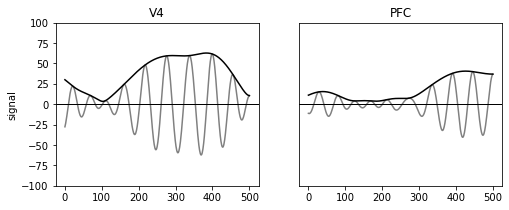

In [12]:
plt.figure(figsize=(8,3))
num_rtime = len(data[0][300:,0,0])

plt.subplot(1,2,1); 
plt.plot(np.linspace(0,500, num_rtime), data[0][300:,95,86], color='grey')
plt.plot(np.linspace(0,500, num_rtime), np.abs(data[0][300:,95,86]), color='black')
plt.title('V4');  plt.ylabel(r'signal') # plt.xlabel('time $t$ (ms)');
plt.axhline(y=0, color='black', linewidth=1); 
plt.ylim(-100,100)

plt.subplot(1,2,2); 
plt.plot(np.linspace(0,500, num_rtime), data[1][300:,15,86], color='grey')
plt.plot(np.linspace(0,500, num_rtime), np.abs(data[1][300:,15,86]), color='black')
plt.axhline(y=0, color='black', linewidth=1); 
plt.ylim(-100,100); plt.yticks([],[])
plt.title('PFC'); # plt.xlabel('time $t$ (ms)'); # plt.ylabel(r'$\|\beta^{(t)}\|^2$')

plt.show()

In [57]:
data = [
    np.abs(d)[300::5,:,:] for d in data
]

In [58]:
data[0].shape, data[1].shape

((101, 96, 3000), (101, 96, 3000))

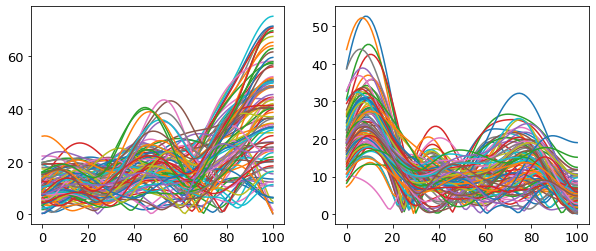

In [59]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1); plt.plot(data[0][:,:,0])
plt.subplot(1,2,2); plt.plot(data[1][:,:,0])
plt.show()

In [60]:
dims = [data[0].shape[1], data[1].shape[1]]
num_time = data[0].shape[0]
num_trial = data[0].shape[2]

# 1. parameter calibration

## diagonal regularization

In [20]:
cwt_omega = 5 # 10/3 
cwt_scale = cwt_omega * 200 / (2 * 18 * np.pi)

In [21]:
lambdas_diag = np.array([1, 2, 3, 5, 10, 20, 30, 50])
W_diagmean = np.zeros([len(lambdas_diag), num_time-1])
SW_ratio = np.zeros(len(lambdas_diag))
SW_error = np.zeros(len(lambdas_diag))

In [22]:
filter_mat = np.exp(-0.5*((np.arange(num_time)[:,None]
                          -np.arange(num_time))/cwt_scale)**2)
filter_mat[np.eye(num_time).astype(bool)]=0

In [23]:
for i, l_i in enumerate(lambdas_diag):
    Omegas_bar = np.concatenate([
    np.array([np.linalg.inv(np.corrcoef(dat[:,i,:]) + l_i * np.eye(num_time)) 
              for i in np.arange(d)])
    for d, dat in zip(dims, data)])
    Omegas_bar[np.array([np.eye(num_time).astype(bool)]*np.sum(dims))]=0
    
    W_diagmean[i] = np.array([
        np.mean(np.diagonal(np.mean(Omegas_bar, 0), k))
        for k in np.arange(1,num_time)
    ])
    
    SW_ratio[i] = np.sum(filter_mat*Omegas_bar) / np.sum(Omegas_bar**2)

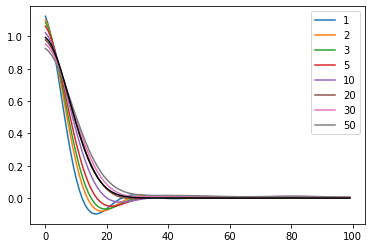

In [24]:
lineObjects = plt.plot(SW_ratio * W_diagmean.T)
plt.plot(np.exp(-0.5*(np.arange(1,num_time)/cwt_scale)**2),
         color='black')
plt.legend(iter(lineObjects), lambdas_diag)

In [25]:
np.sum((SW_ratio[:,None] * W_diagmean 
 - np.array(
     [np.mean(np.diagonal(filter_mat, k)) 
      for k in np.arange(1,num_time)]))**2, 1)

array([1.19638484, 0.73381097, 0.49869404, 0.25890555, 0.05915839,
       0.00588593, 0.0262304 , 0.08038878])

In [26]:
offset_cross=20
offset_auto=20
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.zeros(11), ## lambdas_auto
    np.full((11,), 10), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [27]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [28]:
b_time = np.linspace(rec_time[0], rec_time[1], num_time)
l_time = np.linspace(rec_time[0], rec_time[1], 2*num_time-1)

In [29]:
num_cv = 10

In [30]:
Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
weights_cv = []

for iter_cv in np.arange(num_cv):
    start_cv = time.time()
    
    # random sample
    trial_sample = np.random.choice(num_trial, num_trial, False)
    data_bst = [data[0], data[1][:,:,trial_sample]]

    for iter_est, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
    in enumerate(zip(*lambdas)): 
        if iter_cv > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est],
                        'weight_init': weights_cv[iter_est]}
        elif iter_est > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est-1],
                        'weight_init': weights_cv[iter_est-1]}
        else:
            init_arg = dict()

        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                   lambda_auto, offset_auto, 
                   ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                   **init_arg)
        
        # save result
        Omegas_cv[iter_cv, iter_est] = Omega_est
        if iter_cv == 0:
            weights_cv.append(weight_est)

    sys.__stdout__.write("%d-th cv finished, lapse: %.3fsec.\n"
                         %(iter_cv+1, time.time()-start_cv))
    sys.__stdout__.flush()

1-th iter, nll: 678.538104, change: 0.104331, lapse: 1.270623
2-th iter, nll: 678.470979, change: 0.064713, lapse: 1.316279
3-th iter, nll: 678.426680, change: 0.032828, lapse: 1.235901
4-th iter, nll: 678.394440, change: 0.027807, lapse: 1.281778
5-th iter, nll: 678.369652, change: 0.024890, lapse: 1.239761
6-th iter, nll: 678.349872, change: 0.023058, lapse: 1.304939
7-th iter, nll: 678.333670, change: 0.021540, lapse: 1.196855
8-th iter, nll: 678.320156, change: 0.020037, lapse: 1.192239
9-th iter, nll: 678.308759, change: 0.018480, lapse: 1.182234
10-th iter, nll: 678.299099, change: 0.016899, lapse: 1.179944
11-th iter, nll: 678.290906, change: 0.015352, lapse: 1.201880
12-th iter, nll: 678.283981, change: 0.014433, lapse: 1.177653
13-th iter, nll: 678.278158, change: 0.013661, lapse: 1.197737
14-th iter, nll: 678.273295, change: 0.012652, lapse: 1.189504
15-th iter, nll: 678.269263, change: 0.011499, lapse: 1.189573
16-th iter, nll: 678.265943, change: 0.010288, lapse: 1.222395
1

2-th iter, nll: 678.250781, change: 0.001025, lapse: 1.246967
3-th iter, nll: 678.250740, change: 0.000551, lapse: 1.273845
1-th iter, nll: 678.250772, change: 0.060773, lapse: 1.382151
2-th iter, nll: 678.250699, change: 0.001064, lapse: 1.267690
3-th iter, nll: 678.250656, change: 0.000574, lapse: 1.234020
4-th cv finished, lapse: 26.643sec.
1-th iter, nll: 678.252083, change: 0.000761, lapse: 1.077942
1-th iter, nll: 678.251995, change: 0.000654, lapse: 1.058257
1-th iter, nll: 678.251856, change: 0.008606, lapse: 1.075538
2-th iter, nll: 678.251800, change: 0.000417, lapse: 1.102762
1-th iter, nll: 678.251704, change: 0.024357, lapse: 1.059571
2-th iter, nll: 678.251660, change: 0.000342, lapse: 1.060144
1-th iter, nll: 678.251404, change: 0.034262, lapse: 1.197652
2-th iter, nll: 678.251362, change: 0.000615, lapse: 0.993963
1-th iter, nll: 678.251013, change: 0.044121, lapse: 1.191446
2-th iter, nll: 678.250963, change: 0.000986, lapse: 1.080733
1-th iter, nll: 678.250625, change

2-th iter, nll: 678.250399, change: 0.001431, lapse: 1.151828
3-th iter, nll: 678.250351, change: 0.000776, lapse: 1.112195
1-th iter, nll: 678.250369, change: 0.066669, lapse: 1.363687
2-th iter, nll: 678.250287, change: 0.001465, lapse: 1.189445
3-th iter, nll: 678.250236, change: 0.000795, lapse: 1.202702
1-th iter, nll: 678.250298, change: 0.067869, lapse: 1.395539
2-th iter, nll: 678.250212, change: 0.001485, lapse: 1.249185
3-th iter, nll: 678.250161, change: 0.000808, lapse: 1.249097
9-th cv finished, lapse: 30.519sec.
1-th iter, nll: 678.252083, change: 0.000761, lapse: 1.060396
1-th iter, nll: 678.251995, change: 0.000654, lapse: 1.074426
1-th iter, nll: 678.251853, change: 0.008577, lapse: 1.049567
2-th iter, nll: 678.251798, change: 0.000417, lapse: 1.058676
1-th iter, nll: 678.251659, change: 0.024086, lapse: 1.120385
2-th iter, nll: 678.251615, change: 0.000586, lapse: 1.045518
1-th iter, nll: 678.251387, change: 0.040869, lapse: 1.163607
2-th iter, nll: 678.251345, change

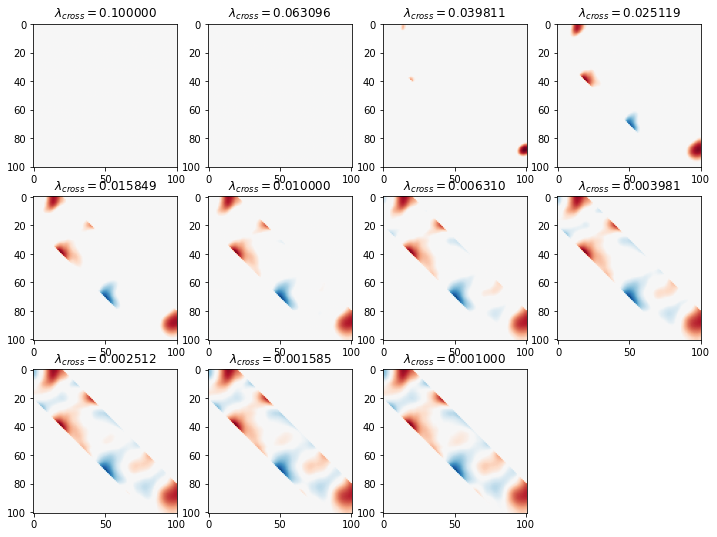

In [31]:
plt.figure(figsize=(12,3*np.ceil(lambdas.shape[-1]/4)))
for iter_lambda, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
in enumerate(zip(*lambdas)):
    plt.subplot(np.ceil(lambdas.shape[-1]/4).astype(int), 4, iter_lambda+1)
    ldn.imshow(Omegas_cv[0, iter_lambda,:num_time,num_time:], identity=True)
    plt.title(r'$\lambda_{cross} = %f$'%lambda_cross)

In [32]:
fds_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/num_cv
fdrs_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/np.sum(time_graph_cross)/num_cv

Text(0, 0.5, 'mean false discovery')

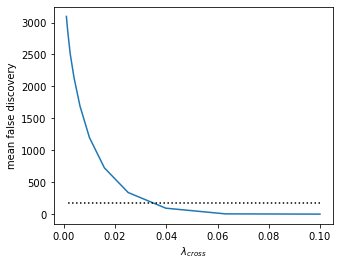

In [33]:
plt.figure(figsize=(5,4))
plt.plot(lambdas[0], fds_cv)
plt.plot(lambdas[0], np.full(lambdas[0].shape, 0.05*np.sum(time_graph_cross)), color='black', linestyle=':')
plt.xlabel(r"$\lambda_{cross}$")
plt.ylabel(r"mean false discovery")

# cv result

In [20]:
id_cv = np.argmax(fdrs_cv[fdrs_cv < 0.05])

In [37]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[id_cv]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

(0.03981071705534973, 0.0, 10.0, 0.0)

In [38]:
lambda_graph = np.array(np.block(
    [[(1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time), (1+lambda_cross)*time_graph_cross],
     [(1+lambda_cross)*time_graph_cross, (1+lambda_auto)*(time_graph_auto-np.eye(num_time)) + (1+lambda_diag)*np.eye(num_time)]])) -1

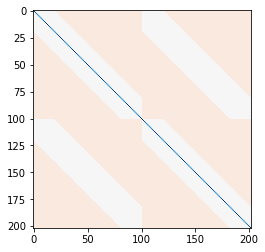

In [39]:
ldn.imshow(lambda_graph)

In [40]:
Omega_est, Sigma_est, latent_est, weight_est =\
    ldn.fit(data, lambda_diag, lambda_cross, offset_cross,
            lambda_auto, offset_auto, 
            ths_glasso=1e-6, ths_lasso=1e-6, verbose=True)

1-th iter, nll: 678.537208, change: 0.104331, lapse: 1.225571
2-th iter, nll: 678.470083, change: 0.064712, lapse: 1.282616
3-th iter, nll: 678.425777, change: 0.032793, lapse: 1.207089
4-th iter, nll: 678.393520, change: 0.027794, lapse: 1.227532
5-th iter, nll: 678.368706, change: 0.024888, lapse: 1.209219
6-th iter, nll: 678.348900, change: 0.023062, lapse: 1.227943
7-th iter, nll: 678.332672, change: 0.021546, lapse: 1.136996
8-th iter, nll: 678.319138, change: 0.020045, lapse: 1.136219
9-th iter, nll: 678.307725, change: 0.018489, lapse: 1.157844
10-th iter, nll: 678.298052, change: 0.016907, lapse: 1.140411
11-th iter, nll: 678.289850, change: 0.015358, lapse: 1.176508
12-th iter, nll: 678.282917, change: 0.014433, lapse: 1.131282
13-th iter, nll: 678.277089, change: 0.013663, lapse: 1.129246
14-th iter, nll: 678.272222, change: 0.012655, lapse: 1.151982
15-th iter, nll: 678.268187, change: 0.011503, lapse: 1.126288
16-th iter, nll: 678.264865, change: 0.010291, lapse: 1.142964
1

## plots

Text(0, 0.5, 'V4 at time $s$ ms')

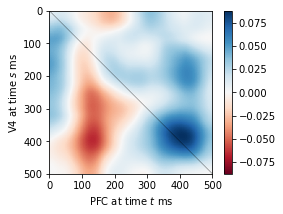

In [33]:
plt.figure(figsize=(4,3))
ldn.imshow(Sigma_est[:num_time,num_time:], time=rec_time, identity=True); plt.colorbar()
plt.xlabel(r"PFC at time $t$ ms"); plt.ylabel(r"V4 at time $s$ ms")

(0.0, 0.047)

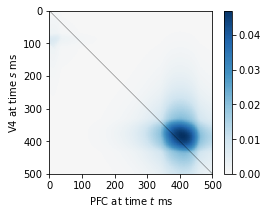

In [241]:
plt.figure(figsize=(4,3))
ldn.imshow(np.linalg.inv(Omega_est)[:num_time,num_time:], time=rec_time, identity=True)
plt.xlabel(r"PFC at time $t$ ms"); plt.ylabel(r"V4 at time $s$ ms")
cbar = plt.colorbar()
cbar.ax.set_ylim(0,0.047)#; cbar.formatter.set_powerlimits((0, 0))

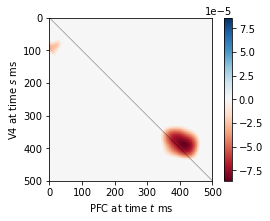

In [35]:
plt.figure(figsize=(4,3))
ldn.imshow(Omega_est[:num_time,num_time:], time=rec_time, identity=True)
plt.xlabel(r"PFC at time $t$ ms"); plt.ylabel(r"V4 at time $s$ ms")
plt.colorbar()

# 2. Permutation test

In [35]:
num_perm = 2000

In [36]:
init_arg = {'Omega_init': Omegas_cv[0,id_cv],
            'weight_init': weights_cv[id_cv]}

In [42]:
Omegas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])
Sigmas_perm = np.zeros([num_perm, 2*num_time, 2*num_time])

for iter_perm in range(num_perm):    
    while True:
        with np.errstate(all='raise'):
            try:
                start_perm = time.time()
                
                # random sample
                trial_sample = np.random.choice(num_trial, num_trial, False)
                data_bst = [data[0], data[1][:,:,trial_sample]]

                # permutation
                Omega_perm, Sigma_perm, latent_perm, weight_perm \
                = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                          lambda_auto, offset_auto, 
                          ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                          **init_arg)
        
                
            except FloatingPointError:
                sys.__stdout__.write("%d-th permutation encountered FloatingPointError, lapse:%.3fsec.\n"
                                     %(iter_perm+1, time.time()-start_perm))
                sys.__stdout__.write("Retrying...\n")
                sys.__stdout__.flush()
                continue
                
            init_arg = {'Omega_init':Omega_perm, 'weight_init':weight_perm}
                        
            # save result
            Omegas_perm[iter_perm] = Omega_perm
            Sigmas_perm[iter_perm] = Sigma_perm
            
            sys.__stdout__.write("%d-th permutation finished, lapse: %.3fsec.\n"
                          %(iter_perm+1, time.time()-start_perm))
            sys.__stdout__.flush()
            break

1-th iter, nll: 814.057051, change: 0.026187, lapse: 2.934476
2-th iter, nll: 814.057015, change: 0.000990, lapse: 3.591146
1-th permutation finished, lapse: 7.223sec.
1-th iter, nll: 814.057080, change: 0.024555, lapse: 2.147271
2-th iter, nll: 814.057054, change: 0.000337, lapse: 1.612651
2-th permutation finished, lapse: 4.347sec.
1-th iter, nll: 814.057043, change: 0.011524, lapse: 1.439391
2-th iter, nll: 814.057024, change: 0.000217, lapse: 1.923294
3-th permutation finished, lapse: 3.939sec.
1-th iter, nll: 814.057007, change: 0.000184, lapse: 2.507611
4-th permutation finished, lapse: 3.047sec.
1-th iter, nll: 814.056992, change: 0.000156, lapse: 1.839379
5-th permutation finished, lapse: 2.437sec.
1-th iter, nll: 814.056972, change: 0.008995, lapse: 1.853210
2-th iter, nll: 814.056959, change: 0.000304, lapse: 2.491796
6-th permutation finished, lapse: 4.999sec.
1-th iter, nll: 814.056907, change: 0.016889, lapse: 2.602666
2-th iter, nll: 814.056897, change: 0.000607, lapse: 2

2-th iter, nll: 814.056829, change: 0.000256, lapse: 2.179457
52-th permutation finished, lapse: 5.161sec.
1-th iter, nll: 814.056834, change: 0.009068, lapse: 1.584720
2-th iter, nll: 814.056834, change: 0.000017, lapse: 1.385144
53-th permutation finished, lapse: 3.497sec.
1-th iter, nll: 814.056834, change: 0.000006, lapse: 1.678569
54-th permutation finished, lapse: 2.490sec.
1-th iter, nll: 814.056827, change: 0.011443, lapse: 2.759876
2-th iter, nll: 814.056827, change: 0.000293, lapse: 1.701957
55-th permutation finished, lapse: 5.312sec.
1-th iter, nll: 814.056833, change: 0.011774, lapse: 1.469533
2-th iter, nll: 814.056833, change: 0.000112, lapse: 1.381528
56-th permutation finished, lapse: 3.393sec.
1-th iter, nll: 814.056834, change: 0.007498, lapse: 1.369689
2-th iter, nll: 814.056833, change: 0.000008, lapse: 1.305704
57-th permutation finished, lapse: 3.209sec.
1-th iter, nll: 814.056833, change: 0.000003, lapse: 1.643130
58-th permutation finished, lapse: 2.429sec.
1-t

1-th iter, nll: 814.056833, change: 0.000001, lapse: 1.386357
105-th permutation finished, lapse: 1.994sec.
1-th iter, nll: 814.056833, change: 0.000001, lapse: 1.958163
106-th permutation finished, lapse: 2.778sec.
1-th iter, nll: 814.056827, change: 0.011707, lapse: 1.923992
2-th iter, nll: 814.056827, change: 0.000324, lapse: 1.755747
107-th permutation finished, lapse: 4.270sec.
1-th iter, nll: 814.056830, change: 0.013370, lapse: 1.819033
2-th iter, nll: 814.056830, change: 0.000212, lapse: 1.469701
108-th permutation finished, lapse: 4.051sec.
1-th iter, nll: 814.056832, change: 0.008142, lapse: 2.315080
2-th iter, nll: 814.056832, change: 0.000198, lapse: 2.058481
109-th permutation finished, lapse: 4.952sec.
1-th iter, nll: 814.056833, change: 0.006557, lapse: 1.699107
2-th iter, nll: 814.056833, change: 0.000102, lapse: 1.800727
110-th permutation finished, lapse: 4.034sec.
1-th iter, nll: 814.056832, change: 0.007134, lapse: 1.526809
2-th iter, nll: 814.056832, change: 0.0001

2-th iter, nll: 814.056833, change: 0.000056, lapse: 2.274415
156-th permutation finished, lapse: 4.697sec.
1-th iter, nll: 814.056816, change: 0.015714, lapse: 1.529002
2-th iter, nll: 814.056815, change: 0.000625, lapse: 1.997853
157-th permutation finished, lapse: 4.208sec.
1-th iter, nll: 814.056833, change: 0.016315, lapse: 1.998953
2-th iter, nll: 814.056833, change: 0.000098, lapse: 1.308229
158-th permutation finished, lapse: 4.098sec.
1-th iter, nll: 814.056825, change: 0.013003, lapse: 1.497258
2-th iter, nll: 814.056825, change: 0.000366, lapse: 2.588021
159-th permutation finished, lapse: 4.664sec.
1-th iter, nll: 814.056833, change: 0.013280, lapse: 1.920546
2-th iter, nll: 814.056833, change: 0.000048, lapse: 1.925013
160-th permutation finished, lapse: 4.475sec.
1-th iter, nll: 814.056833, change: 0.001719, lapse: 1.908463
2-th iter, nll: 814.056833, change: 0.000004, lapse: 2.045110
161-th permutation finished, lapse: 4.742sec.
1-th iter, nll: 814.056814, change: 0.0115

1-th iter, nll: 814.056833, change: 0.000007, lapse: 1.978677
209-th permutation finished, lapse: 2.751sec.
1-th iter, nll: 814.056830, change: 0.007341, lapse: 1.333220
2-th iter, nll: 814.056830, change: 0.000197, lapse: 1.655051
210-th permutation finished, lapse: 3.593sec.
1-th iter, nll: 814.056833, change: 0.007538, lapse: 2.151700
2-th iter, nll: 814.056833, change: 0.000010, lapse: 2.294226
211-th permutation finished, lapse: 5.118sec.
1-th iter, nll: 814.056833, change: 0.000004, lapse: 1.458665
212-th permutation finished, lapse: 2.070sec.
1-th iter, nll: 814.056833, change: 0.000002, lapse: 1.465794
213-th permutation finished, lapse: 2.038sec.
1-th iter, nll: 814.056810, change: 0.014832, lapse: 1.565945
2-th iter, nll: 814.056809, change: 0.000586, lapse: 3.551538
214-th permutation finished, lapse: 5.854sec.
1-th iter, nll: 814.056834, change: 0.015403, lapse: 1.591541
2-th iter, nll: 814.056834, change: 0.000021, lapse: 2.154539
215-th permutation finished, lapse: 4.355s

1-th iter, nll: 814.056832, change: 0.006582, lapse: 1.589191
2-th iter, nll: 814.056832, change: 0.000234, lapse: 1.441411
261-th permutation finished, lapse: 3.637sec.
1-th iter, nll: 814.056833, change: 0.006816, lapse: 1.239954
2-th iter, nll: 814.056833, change: 0.000004, lapse: 1.567534
262-th permutation finished, lapse: 3.440sec.
1-th iter, nll: 814.056833, change: 0.000001, lapse: 2.575064
263-th permutation finished, lapse: 3.198sec.
1-th iter, nll: 814.056833, change: 0.000526, lapse: 1.332879
264-th permutation finished, lapse: 1.951sec.
1-th iter, nll: 814.056833, change: 0.002847, lapse: 1.434198
2-th iter, nll: 814.056833, change: 0.000109, lapse: 2.054465
265-th permutation finished, lapse: 4.061sec.
1-th iter, nll: 814.056833, change: 0.002951, lapse: 2.397264
2-th iter, nll: 814.056833, change: 0.000002, lapse: 1.348943
266-th permutation finished, lapse: 4.433sec.
1-th iter, nll: 814.056832, change: 0.005987, lapse: 1.593155
2-th iter, nll: 814.056832, change: 0.0001

1-th iter, nll: 814.056833, change: 0.015549, lapse: 2.108417
2-th iter, nll: 814.056833, change: 0.000016, lapse: 1.652186
311-th permutation finished, lapse: 4.562sec.
1-th iter, nll: 814.056833, change: 0.002537, lapse: 1.480850
2-th iter, nll: 814.056833, change: 0.000055, lapse: 1.583155
312-th permutation finished, lapse: 3.669sec.
1-th iter, nll: 814.056824, change: 0.009568, lapse: 2.849478
2-th iter, nll: 814.056824, change: 0.000451, lapse: 2.296609
313-th permutation finished, lapse: 5.913sec.
1-th iter, nll: 814.056827, change: 0.010746, lapse: 1.824428
2-th iter, nll: 814.056827, change: 0.000296, lapse: 1.294228
314-th permutation finished, lapse: 3.692sec.
1-th iter, nll: 814.056812, change: 0.015214, lapse: 1.400638
2-th iter, nll: 814.056811, change: 0.000647, lapse: 1.295589
315-th permutation finished, lapse: 3.436sec.
1-th iter, nll: 814.056830, change: 0.016296, lapse: 1.727374
2-th iter, nll: 814.056830, change: 0.000332, lapse: 1.715999
316-th permutation finishe

2-th iter, nll: 814.056833, change: 0.000019, lapse: 1.242895
359-th permutation finished, lapse: 3.444sec.
1-th iter, nll: 814.056832, change: 0.004598, lapse: 2.023091
2-th iter, nll: 814.056832, change: 0.000135, lapse: 1.826800
360-th permutation finished, lapse: 4.574sec.
1-th iter, nll: 814.056833, change: 0.004733, lapse: 1.424963
2-th iter, nll: 814.056833, change: 0.000006, lapse: 2.133031
361-th permutation finished, lapse: 4.238sec.
1-th iter, nll: 814.056810, change: 0.016181, lapse: 1.547563
2-th iter, nll: 814.056810, change: 0.000430, lapse: 1.511536
362-th permutation finished, lapse: 3.662sec.
1-th iter, nll: 814.056495, change: 0.046479, lapse: 1.490810
2-th iter, nll: 814.056487, change: 0.001776, lapse: 1.895929
3-th iter, nll: 814.056483, change: 0.000950, lapse: 2.428912
363-th permutation finished, lapse: 6.468sec.
1-th iter, nll: 814.056840, change: 0.049479, lapse: 1.425644
2-th iter, nll: 814.056836, change: 0.000236, lapse: 1.419730
364-th permutation finishe

1-th iter, nll: 814.056833, change: 0.011478, lapse: 1.881468
2-th iter, nll: 814.056833, change: 0.000095, lapse: 1.403735
408-th permutation finished, lapse: 4.108sec.
1-th iter, nll: 814.056833, change: 0.004704, lapse: 1.756320
2-th iter, nll: 814.056833, change: 0.000004, lapse: 1.845424
409-th permutation finished, lapse: 4.286sec.
1-th iter, nll: 814.056833, change: 0.000003, lapse: 2.033631
410-th permutation finished, lapse: 2.730sec.
1-th iter, nll: 814.056833, change: 0.000045, lapse: 1.817645
411-th permutation finished, lapse: 2.475sec.
1-th iter, nll: 814.056833, change: 0.000045, lapse: 1.591926
412-th permutation finished, lapse: 2.183sec.
1-th iter, nll: 814.056833, change: 0.000002, lapse: 1.287857
413-th permutation finished, lapse: 1.906sec.
1-th iter, nll: 814.056827, change: 0.011713, lapse: 1.420917
2-th iter, nll: 814.056827, change: 0.000329, lapse: 2.063679
414-th permutation finished, lapse: 4.067sec.
1-th iter, nll: 814.056826, change: 0.012041, lapse: 2.346

1-th iter, nll: 814.056770, change: 0.026373, lapse: 1.495944
2-th iter, nll: 814.056769, change: 0.000785, lapse: 2.106318
460-th permutation finished, lapse: 4.261sec.
1-th iter, nll: 814.056834, change: 0.027086, lapse: 1.670865
2-th iter, nll: 814.056834, change: 0.000060, lapse: 1.576112
461-th permutation finished, lapse: 3.873sec.
1-th iter, nll: 814.056833, change: 0.004387, lapse: 1.590621
2-th iter, nll: 814.056833, change: 0.000138, lapse: 2.211642
462-th permutation finished, lapse: 4.411sec.
1-th iter, nll: 814.056833, change: 0.004585, lapse: 1.361694
2-th iter, nll: 814.056833, change: 0.000008, lapse: 1.946070
463-th permutation finished, lapse: 3.916sec.
1-th iter, nll: 814.056833, change: 0.001066, lapse: 1.648307
2-th iter, nll: 814.056833, change: 0.000003, lapse: 1.229407
464-th permutation finished, lapse: 3.476sec.
1-th iter, nll: 814.056829, change: 0.009918, lapse: 1.460046
2-th iter, nll: 814.056829, change: 0.000334, lapse: 2.113490
465-th permutation finishe

1-th iter, nll: 814.056833, change: 0.001289, lapse: 2.548384
2-th iter, nll: 814.056833, change: 0.000008, lapse: 2.087845
511-th permutation finished, lapse: 5.422sec.
1-th iter, nll: 814.056833, change: 0.000004, lapse: 1.414524
512-th permutation finished, lapse: 2.144sec.
1-th iter, nll: 814.056833, change: 0.000002, lapse: 2.510851
513-th permutation finished, lapse: 3.201sec.
1-th iter, nll: 814.056826, change: 0.010249, lapse: 2.081874
2-th iter, nll: 814.056826, change: 0.000262, lapse: 1.771443
514-th permutation finished, lapse: 4.629sec.
1-th iter, nll: 814.056833, change: 0.010486, lapse: 2.823529
2-th iter, nll: 814.056833, change: 0.000050, lapse: 2.631921
515-th permutation finished, lapse: 6.351sec.
1-th iter, nll: 814.056792, change: 0.022921, lapse: 2.204301
2-th iter, nll: 814.056791, change: 0.001026, lapse: 2.084894
3-th iter, nll: 814.056790, change: 0.000448, lapse: 2.938551
516-th permutation finished, lapse: 7.996sec.
1-th iter, nll: 814.056834, change: 0.0243

2-th iter, nll: 814.056822, change: 0.000362, lapse: 1.928441
562-th permutation finished, lapse: 4.551sec.
1-th iter, nll: 814.056829, change: 0.011825, lapse: 1.493627
2-th iter, nll: 814.056829, change: 0.000460, lapse: 2.034996
563-th permutation finished, lapse: 4.117sec.
1-th iter, nll: 814.056833, change: 0.011825, lapse: 1.701883
2-th iter, nll: 814.056833, change: 0.000017, lapse: 1.496591
564-th permutation finished, lapse: 3.892sec.
1-th iter, nll: 814.056833, change: 0.000010, lapse: 2.120248
565-th permutation finished, lapse: 2.873sec.
1-th iter, nll: 814.056833, change: 0.002951, lapse: 1.455008
2-th iter, nll: 814.056833, change: 0.000027, lapse: 1.633460
566-th permutation finished, lapse: 3.658sec.
1-th iter, nll: 814.056833, change: 0.003571, lapse: 2.164914
2-th iter, nll: 814.056833, change: 0.000088, lapse: 2.190196
567-th permutation finished, lapse: 5.049sec.
1-th iter, nll: 814.056833, change: 0.003568, lapse: 1.521612
2-th iter, nll: 814.056833, change: 0.0000

1-th iter, nll: 814.056834, change: 0.000015, lapse: 2.208405
612-th permutation finished, lapse: 2.856sec.
1-th iter, nll: 814.056833, change: 0.000012, lapse: 2.195388
613-th permutation finished, lapse: 2.834sec.
1-th iter, nll: 814.056832, change: 0.006269, lapse: 1.503030
2-th iter, nll: 814.056832, change: 0.000157, lapse: 2.127516
614-th permutation finished, lapse: 4.341sec.
1-th iter, nll: 814.056789, change: 0.015580, lapse: 2.211252
2-th iter, nll: 814.056789, change: 0.000682, lapse: 2.360064
615-th permutation finished, lapse: 5.306sec.
1-th iter, nll: 814.056831, change: 0.016154, lapse: 1.873353
2-th iter, nll: 814.056831, change: 0.000190, lapse: 2.157982
616-th permutation finished, lapse: 4.718sec.
1-th iter, nll: 814.056833, change: 0.008062, lapse: 1.238458
2-th iter, nll: 814.056833, change: 0.000020, lapse: 1.915189
617-th permutation finished, lapse: 3.826sec.
1-th iter, nll: 814.056832, change: 0.006165, lapse: 1.333887
2-th iter, nll: 814.056832, change: 0.0001

1-th iter, nll: 814.056833, change: 0.011582, lapse: 1.416295
2-th iter, nll: 814.056833, change: 0.000013, lapse: 1.376198
664-th permutation finished, lapse: 3.403sec.
1-th iter, nll: 814.056822, change: 0.009619, lapse: 1.367600
2-th iter, nll: 814.056822, change: 0.000571, lapse: 2.409494
665-th permutation finished, lapse: 4.401sec.
1-th iter, nll: 814.056833, change: 0.010162, lapse: 2.144449
2-th iter, nll: 814.056833, change: 0.000087, lapse: 1.676894
666-th permutation finished, lapse: 4.460sec.
1-th iter, nll: 814.056832, change: 0.006297, lapse: 1.725929
2-th iter, nll: 814.056832, change: 0.000135, lapse: 1.627427
667-th permutation finished, lapse: 3.974sec.
1-th iter, nll: 814.056833, change: 0.006433, lapse: 1.823714
2-th iter, nll: 814.056833, change: 0.000006, lapse: 2.729942
668-th permutation finished, lapse: 5.197sec.
1-th iter, nll: 814.056833, change: 0.000408, lapse: 2.057456
669-th permutation finished, lapse: 2.664sec.
1-th iter, nll: 814.056829, change: 0.0098

2-th iter, nll: 814.056829, change: 0.000237, lapse: 2.285612
714-th permutation finished, lapse: 5.083sec.
1-th iter, nll: 814.056828, change: 0.011324, lapse: 2.114456
2-th iter, nll: 814.056828, change: 0.000296, lapse: 2.175159
715-th permutation finished, lapse: 4.988sec.
1-th iter, nll: 814.056816, change: 0.014928, lapse: 1.489180
2-th iter, nll: 814.056816, change: 0.000629, lapse: 1.529864
716-th permutation finished, lapse: 3.637sec.
1-th iter, nll: 814.056833, change: 0.017113, lapse: 1.558311
2-th iter, nll: 814.056833, change: 0.000093, lapse: 1.671350
717-th permutation finished, lapse: 3.847sec.
1-th iter, nll: 814.056833, change: 0.004649, lapse: 1.836490
2-th iter, nll: 814.056833, change: 0.000007, lapse: 1.459605
718-th permutation finished, lapse: 3.910sec.
1-th iter, nll: 814.056833, change: 0.004803, lapse: 1.896926
2-th iter, nll: 814.056833, change: 0.000076, lapse: 1.851971
719-th permutation finished, lapse: 4.412sec.
1-th iter, nll: 814.056784, change: 0.0257

2-th iter, nll: 814.056829, change: 0.000260, lapse: 1.916073
764-th permutation finished, lapse: 4.158sec.
1-th iter, nll: 814.056833, change: 0.010667, lapse: 1.752804
2-th iter, nll: 814.056833, change: 0.000025, lapse: 2.467969
765-th permutation finished, lapse: 4.916sec.
1-th iter, nll: 814.056833, change: 0.002613, lapse: 1.678187
2-th iter, nll: 814.056833, change: 0.000061, lapse: 1.629924
766-th permutation finished, lapse: 4.137sec.
1-th iter, nll: 814.056833, change: 0.004102, lapse: 1.368336
2-th iter, nll: 814.056833, change: 0.000079, lapse: 2.654053
767-th permutation finished, lapse: 4.634sec.
1-th iter, nll: 814.056828, change: 0.010270, lapse: 1.222680
2-th iter, nll: 814.056828, change: 0.000325, lapse: 2.315443
768-th permutation finished, lapse: 4.254sec.
1-th iter, nll: 814.056832, change: 0.010362, lapse: 3.004255
2-th iter, nll: 814.056832, change: 0.000126, lapse: 1.461666
769-th permutation finished, lapse: 5.255sec.
1-th iter, nll: 814.056833, change: 0.0061

1-th iter, nll: 814.056833, change: 0.005798, lapse: 2.035884
2-th iter, nll: 814.056833, change: 0.000006, lapse: 1.862983
814-th permutation finished, lapse: 4.509sec.
1-th iter, nll: 814.056833, change: 0.000441, lapse: 2.815012
815-th permutation finished, lapse: 3.945sec.
1-th iter, nll: 814.056831, change: 0.010577, lapse: 3.532037
2-th iter, nll: 814.056831, change: 0.000208, lapse: 2.802547
816-th permutation finished, lapse: 7.224sec.
1-th iter, nll: 814.056827, change: 0.010806, lapse: 1.928162
2-th iter, nll: 814.056827, change: 0.000434, lapse: 3.100745
817-th permutation finished, lapse: 6.196sec.
1-th iter, nll: 814.056833, change: 0.010555, lapse: 2.148488
2-th iter, nll: 814.056833, change: 0.000106, lapse: 1.979898
818-th permutation finished, lapse: 4.940sec.
1-th iter, nll: 814.056833, change: 0.005925, lapse: 2.137451
2-th iter, nll: 814.056833, change: 0.000004, lapse: 1.795951
819-th permutation finished, lapse: 4.649sec.
1-th iter, nll: 814.056832, change: 0.0050

1-th iter, nll: 814.056781, change: 0.022376, lapse: 1.688620
2-th iter, nll: 814.056780, change: 0.000902, lapse: 1.980568
865-th permutation finished, lapse: 4.540sec.
1-th iter, nll: 814.056834, change: 0.023254, lapse: 1.714072
2-th iter, nll: 814.056834, change: 0.000039, lapse: 1.434664
866-th permutation finished, lapse: 3.818sec.
1-th iter, nll: 814.056828, change: 0.009935, lapse: 1.365438
2-th iter, nll: 814.056827, change: 0.000323, lapse: 2.333311
867-th permutation finished, lapse: 4.388sec.
1-th iter, nll: 814.056811, change: 0.016717, lapse: 1.876289
2-th iter, nll: 814.056810, change: 0.000570, lapse: 1.872437
868-th permutation finished, lapse: 4.341sec.
1-th iter, nll: 814.056834, change: 0.017313, lapse: 1.873631
2-th iter, nll: 814.056833, change: 0.000026, lapse: 1.595594
869-th permutation finished, lapse: 4.096sec.
1-th iter, nll: 814.056833, change: 0.000010, lapse: 2.213309
870-th permutation finished, lapse: 3.369sec.
1-th iter, nll: 814.056808, change: 0.0177

1-th iter, nll: 814.056834, change: 0.000011, lapse: 2.092531
915-th permutation finished, lapse: 2.886sec.
1-th iter, nll: 814.056834, change: 0.000008, lapse: 1.282313
916-th permutation finished, lapse: 2.003sec.
1-th iter, nll: 814.056833, change: 0.000006, lapse: 2.614693
917-th permutation finished, lapse: 3.354sec.
1-th iter, nll: 814.056832, change: 0.006358, lapse: 1.283934
2-th iter, nll: 814.056832, change: 0.000100, lapse: 2.272192
918-th permutation finished, lapse: 4.161sec.
1-th iter, nll: 814.056833, change: 0.006451, lapse: 1.579843
2-th iter, nll: 814.056833, change: 0.000006, lapse: 1.516121
919-th permutation finished, lapse: 3.839sec.
1-th iter, nll: 814.056833, change: 0.000002, lapse: 2.353450
920-th permutation finished, lapse: 3.065sec.
1-th iter, nll: 814.056833, change: 0.000002, lapse: 2.042117
921-th permutation finished, lapse: 2.707sec.
1-th iter, nll: 814.056833, change: 0.000001, lapse: 1.984021
922-th permutation finished, lapse: 2.694sec.
1-th iter, n

1-th iter, nll: 814.056833, change: 0.007880, lapse: 1.408472
2-th iter, nll: 814.056833, change: 0.000009, lapse: 3.126551
999-th permutation finished, lapse: 5.266sec.
1-th iter, nll: 814.056800, change: 0.016704, lapse: 2.938880
2-th iter, nll: 814.056798, change: 0.000931, lapse: 2.783037
1000-th permutation finished, lapse: 6.530sec.
1-th iter, nll: 814.056834, change: 0.017472, lapse: 1.768998
2-th iter, nll: 814.056834, change: 0.000027, lapse: 2.133471
1001-th permutation finished, lapse: 5.093sec.
2-th iter, nll: 814.056832, change: 0.000190, lapse: 1.827431
1010-th permutation finished, lapse: 4.413sec.
1-th iter, nll: 814.056833, change: 0.007646, lapse: 2.200973
2-th iter, nll: 814.056833, change: 0.000006, lapse: 1.875221
1011-th permutation finished, lapse: 4.787sec.
1-th iter, nll: 814.056833, change: 0.004241, lapse: 1.577469
2-th iter, nll: 814.056833, change: 0.000096, lapse: 2.276694
1012-th permutation finished, lapse: 4.483sec.
1-th iter, nll: 814.056833, change: 0

2-th iter, nll: 814.056831, change: 0.000182, lapse: 2.068468
1077-th permutation finished, lapse: 4.364sec.
1-th iter, nll: 814.056833, change: 0.009109, lapse: 2.128968
2-th iter, nll: 814.056833, change: 0.000008, lapse: 2.246981
1078-th permutation finished, lapse: 5.324sec.
1-th iter, nll: 814.056833, change: 0.002360, lapse: 1.697646
2-th iter, nll: 814.056833, change: 0.000034, lapse: 2.108868
1079-th permutation finished, lapse: 4.637sec.
1-th iter, nll: 814.056828, change: 0.009872, lapse: 2.948160
2-th iter, nll: 814.056827, change: 0.000361, lapse: 2.595765
1080-th permutation finished, lapse: 6.391sec.
1-th iter, nll: 814.056833, change: 0.010262, lapse: 1.893485
2-th iter, nll: 814.056833, change: 0.000021, lapse: 2.034234
1081-th permutation finished, lapse: 4.808sec.
1-th iter, nll: 814.056833, change: 0.000008, lapse: 1.371700
1082-th permutation finished, lapse: 1.976sec.
1-th iter, nll: 814.056833, change: 0.003398, lapse: 1.617621
2-th iter, nll: 814.056833, change: 

1-th iter, nll: 814.056827, change: 0.018444, lapse: 2.071059
2-th iter, nll: 814.056826, change: 0.000286, lapse: 2.194946
1131-th permutation finished, lapse: 4.961sec.
1-th iter, nll: 814.056833, change: 0.015261, lapse: 2.227504
2-th iter, nll: 814.056833, change: 0.000024, lapse: 2.066593
1132-th permutation finished, lapse: 4.943sec.
1-th iter, nll: 814.056833, change: 0.000006, lapse: 1.984255
1133-th permutation finished, lapse: 2.721sec.
1-th iter, nll: 814.056827, change: 0.010692, lapse: 1.547608
2-th iter, nll: 814.056827, change: 0.000329, lapse: 1.856275
1134-th permutation finished, lapse: 4.073sec.
1-th iter, nll: 814.056832, change: 0.015675, lapse: 1.327645
2-th iter, nll: 814.056832, change: 0.000167, lapse: 2.339485
1135-th permutation finished, lapse: 4.351sec.
1-th iter, nll: 814.056831, change: 0.008026, lapse: 1.968862
2-th iter, nll: 814.056831, change: 0.000222, lapse: 2.201042
1136-th permutation finished, lapse: 4.795sec.
1-th iter, nll: 814.056833, change: 

1-th iter, nll: 814.056833, change: 0.006510, lapse: 2.467292
2-th iter, nll: 814.056833, change: 0.000082, lapse: 2.418054
1182-th permutation finished, lapse: 5.604sec.
1-th iter, nll: 814.056832, change: 0.004756, lapse: 1.822314
2-th iter, nll: 814.056832, change: 0.000116, lapse: 1.270489
1183-th permutation finished, lapse: 3.835sec.
1-th iter, nll: 814.056833, change: 0.004779, lapse: 2.176308
2-th iter, nll: 814.056833, change: 0.000011, lapse: 1.721687
1184-th permutation finished, lapse: 4.476sec.
1-th iter, nll: 814.056832, change: 0.007604, lapse: 1.967907
2-th iter, nll: 814.056831, change: 0.000168, lapse: 1.548098
1185-th permutation finished, lapse: 4.061sec.
1-th iter, nll: 814.056833, change: 0.007769, lapse: 1.190398
2-th iter, nll: 814.056833, change: 0.000050, lapse: 2.146331
1186-th permutation finished, lapse: 3.867sec.
1-th iter, nll: 814.056833, change: 0.003170, lapse: 2.222676
2-th iter, nll: 814.056833, change: 0.000003, lapse: 1.196656
1187-th permutation f

2-th iter, nll: 814.056832, change: 0.000137, lapse: 1.270043
1234-th permutation finished, lapse: 4.371sec.
1-th iter, nll: 814.056833, change: 0.005662, lapse: 2.135230
2-th iter, nll: 814.056833, change: 0.000010, lapse: 1.654427
1235-th permutation finished, lapse: 4.356sec.
1-th iter, nll: 814.056807, change: 0.013943, lapse: 2.779757
2-th iter, nll: 814.056806, change: 0.000573, lapse: 1.384742
1236-th permutation finished, lapse: 4.830sec.
1-th iter, nll: 814.056833, change: 0.014525, lapse: 2.855584
2-th iter, nll: 814.056833, change: 0.000068, lapse: 2.730654
1237-th permutation finished, lapse: 6.286sec.
1-th iter, nll: 814.056833, change: 0.003936, lapse: 2.972578
2-th iter, nll: 814.056833, change: 0.000011, lapse: 3.372573
1238-th permutation finished, lapse: 7.488sec.
1-th iter, nll: 814.056833, change: 0.000005, lapse: 2.503594
1239-th permutation finished, lapse: 3.642sec.
1-th iter, nll: 814.056833, change: 0.000987, lapse: 2.466555
1240-th permutation finished, lapse:

1-th iter, nll: 814.056833, change: 0.004942, lapse: 1.284729
2-th iter, nll: 814.056833, change: 0.000004, lapse: 1.512947
1285-th permutation finished, lapse: 3.349sec.
1-th iter, nll: 814.056832, change: 0.005686, lapse: 1.547752
2-th iter, nll: 814.056832, change: 0.000172, lapse: 1.486840
1286-th permutation finished, lapse: 3.730sec.
1-th iter, nll: 814.056833, change: 0.005858, lapse: 1.227244
2-th iter, nll: 814.056833, change: 0.000005, lapse: 1.737456
1287-th permutation finished, lapse: 3.567sec.
1-th iter, nll: 814.056833, change: 0.000002, lapse: 1.547480
1288-th permutation finished, lapse: 2.158sec.
1-th iter, nll: 814.056833, change: 0.000001, lapse: 2.054330
1289-th permutation finished, lapse: 2.654sec.
1-th iter, nll: 814.056833, change: 0.002447, lapse: 1.462909
2-th iter, nll: 814.056833, change: 0.000047, lapse: 1.305685
1290-th permutation finished, lapse: 3.448sec.
1-th iter, nll: 814.056799, change: 0.015106, lapse: 2.070133
2-th iter, nll: 814.056798, change: 

1-th iter, nll: 814.056731, change: 0.026218, lapse: 1.578452
2-th iter, nll: 814.056729, change: 0.001000, lapse: 1.345602
3-th iter, nll: 814.056728, change: 0.000480, lapse: 2.286433
1336-th permutation finished, lapse: 5.887sec.
1-th iter, nll: 814.056813, change: 0.027359, lapse: 2.026127
2-th iter, nll: 814.056812, change: 0.000574, lapse: 1.731411
1337-th permutation finished, lapse: 4.371sec.
1-th iter, nll: 814.056834, change: 0.017170, lapse: 1.568900
2-th iter, nll: 814.056834, change: 0.000038, lapse: 1.852520
1338-th permutation finished, lapse: 4.160sec.
1-th iter, nll: 814.056823, change: 0.013694, lapse: 2.403695
2-th iter, nll: 814.056822, change: 0.000387, lapse: 2.421439
1339-th permutation finished, lapse: 5.387sec.
1-th iter, nll: 814.056825, change: 0.013972, lapse: 2.901613
2-th iter, nll: 814.056825, change: 0.000303, lapse: 1.783700
1340-th permutation finished, lapse: 5.604sec.
1-th iter, nll: 814.056815, change: 0.020982, lapse: 1.662370
2-th iter, nll: 814.0

2-th iter, nll: 814.056837, change: 0.000075, lapse: 1.565337
1384-th permutation finished, lapse: 3.738sec.
1-th iter, nll: 814.056836, change: 0.000057, lapse: 2.278257
1385-th permutation finished, lapse: 2.825sec.
1-th iter, nll: 814.056835, change: 0.000830, lapse: 2.032904
1386-th permutation finished, lapse: 2.595sec.
1-th iter, nll: 814.056821, change: 0.012405, lapse: 1.831049
2-th iter, nll: 814.056820, change: 0.000412, lapse: 1.631616
1387-th permutation finished, lapse: 4.125sec.
1-th iter, nll: 814.056820, change: 0.014470, lapse: 1.748719
2-th iter, nll: 814.056820, change: 0.000510, lapse: 2.041100
1388-th permutation finished, lapse: 4.466sec.
1-th iter, nll: 814.056831, change: 0.015652, lapse: 2.024968
2-th iter, nll: 814.056831, change: 0.000233, lapse: 1.800663
1389-th permutation finished, lapse: 4.970sec.
1-th iter, nll: 814.056776, change: 0.026031, lapse: 2.196456
2-th iter, nll: 814.056775, change: 0.000685, lapse: 2.021827
1390-th permutation finished, lapse:

2-th iter, nll: 814.056834, change: 0.000059, lapse: 1.708563
1435-th permutation finished, lapse: 3.588sec.
1-th iter, nll: 814.056834, change: 0.001254, lapse: 1.324774
2-th iter, nll: 814.056834, change: 0.000014, lapse: 1.320522
1436-th permutation finished, lapse: 3.475sec.
1-th iter, nll: 814.056829, change: 0.009202, lapse: 1.648797
2-th iter, nll: 814.056828, change: 0.000346, lapse: 1.919336
1437-th permutation finished, lapse: 4.131sec.
1-th iter, nll: 814.056833, change: 0.009536, lapse: 2.181953
2-th iter, nll: 814.056833, change: 0.000052, lapse: 3.340616
1438-th permutation finished, lapse: 6.205sec.
1-th iter, nll: 814.056833, change: 0.001482, lapse: 4.315093
2-th iter, nll: 814.056833, change: 0.000005, lapse: 2.983089
1439-th permutation finished, lapse: 8.209sec.
1-th iter, nll: 814.056833, change: 0.000003, lapse: 3.092791
1440-th permutation finished, lapse: 4.318sec.
1-th iter, nll: 814.056813, change: 0.011987, lapse: 2.819618
2-th iter, nll: 814.056812, change: 

1-th iter, nll: 814.056828, change: 0.010791, lapse: 1.799355
2-th iter, nll: 814.056828, change: 0.000256, lapse: 2.116560
1486-th permutation finished, lapse: 4.605sec.
1-th iter, nll: 814.056833, change: 0.008197, lapse: 2.023976
2-th iter, nll: 814.056833, change: 0.000010, lapse: 2.564476
1487-th permutation finished, lapse: 5.297sec.
1-th iter, nll: 814.056812, change: 0.013224, lapse: 1.862181
2-th iter, nll: 814.056812, change: 0.000448, lapse: 1.745291
1488-th permutation finished, lapse: 4.179sec.
1-th iter, nll: 814.056834, change: 0.013669, lapse: 1.473652
2-th iter, nll: 814.056833, change: 0.000049, lapse: 2.925560
1489-th permutation finished, lapse: 4.975sec.
1-th iter, nll: 814.056833, change: 0.002768, lapse: 2.729773
2-th iter, nll: 814.056833, change: 0.000009, lapse: 1.688502
1490-th permutation finished, lapse: 5.077sec.
1-th iter, nll: 814.056833, change: 0.000006, lapse: 2.256276
1491-th permutation finished, lapse: 2.995sec.
1-th iter, nll: 814.056833, change: 

1-th iter, nll: 814.056833, change: 0.003550, lapse: 2.157404
2-th iter, nll: 814.056833, change: 0.000012, lapse: 1.837162
1538-th permutation finished, lapse: 4.552sec.
1-th iter, nll: 814.056833, change: 0.000006, lapse: 1.390291
1539-th permutation finished, lapse: 1.951sec.
1-th iter, nll: 814.056833, change: 0.000004, lapse: 1.985300
1540-th permutation finished, lapse: 2.623sec.
1-th iter, nll: 814.056833, change: 0.000003, lapse: 1.670878
1541-th permutation finished, lapse: 2.331sec.
1-th iter, nll: 814.056817, change: 0.014007, lapse: 2.797570
2-th iter, nll: 814.056816, change: 0.000549, lapse: 2.103405
1542-th permutation finished, lapse: 5.469sec.
1-th iter, nll: 814.056811, change: 0.017923, lapse: 1.918340
2-th iter, nll: 814.056811, change: 0.000596, lapse: 1.591461
1543-th permutation finished, lapse: 4.332sec.
1-th iter, nll: 814.056833, change: 0.018529, lapse: 1.912875
2-th iter, nll: 814.056833, change: 0.000084, lapse: 1.535612
1544-th permutation finished, lapse:

2-th iter, nll: 814.056832, change: 0.000171, lapse: 1.977087
1588-th permutation finished, lapse: 4.779sec.
1-th iter, nll: 814.056830, change: 0.006293, lapse: 1.983891
2-th iter, nll: 814.056830, change: 0.000220, lapse: 1.381358
1589-th permutation finished, lapse: 4.055sec.
1-th iter, nll: 814.056833, change: 0.006070, lapse: 1.543124
2-th iter, nll: 814.056833, change: 0.000007, lapse: 1.323961
1590-th permutation finished, lapse: 3.587sec.
1-th iter, nll: 814.056799, change: 0.015351, lapse: 2.417882
2-th iter, nll: 814.056798, change: 0.000433, lapse: 1.917025
1591-th permutation finished, lapse: 5.016sec.
1-th iter, nll: 814.056820, change: 0.015737, lapse: 1.402199
2-th iter, nll: 814.056820, change: 0.000524, lapse: 2.081293
1592-th permutation finished, lapse: 4.193sec.
1-th iter, nll: 814.056834, change: 0.013829, lapse: 1.548070
2-th iter, nll: 814.056834, change: 0.000019, lapse: 1.876959
1593-th permutation finished, lapse: 4.120sec.
1-th iter, nll: 814.056833, change: 

1-th iter, nll: 814.056830, change: 0.008384, lapse: 1.824791
2-th iter, nll: 814.056830, change: 0.000214, lapse: 2.283659
1639-th permutation finished, lapse: 4.715sec.
1-th iter, nll: 814.056833, change: 0.008249, lapse: 1.391669
2-th iter, nll: 814.056833, change: 0.000020, lapse: 1.565267
1640-th permutation finished, lapse: 3.608sec.
1-th iter, nll: 814.056821, change: 0.015939, lapse: 1.826574
2-th iter, nll: 814.056821, change: 0.000453, lapse: 1.343078
1641-th permutation finished, lapse: 3.804sec.
1-th iter, nll: 814.056833, change: 0.016342, lapse: 1.638853
2-th iter, nll: 814.056833, change: 0.000023, lapse: 1.776186
1642-th permutation finished, lapse: 3.974sec.
1-th iter, nll: 814.056833, change: 0.000005, lapse: 1.393443
1643-th permutation finished, lapse: 1.960sec.
1-th iter, nll: 814.056808, change: 0.017386, lapse: 1.848295
2-th iter, nll: 814.056807, change: 0.000735, lapse: 2.874342
1644-th permutation finished, lapse: 5.317sec.
1-th iter, nll: 814.056832, change: 

2-th iter, nll: 814.056833, change: 0.000032, lapse: 1.222167
1688-th permutation finished, lapse: 3.512sec.
1-th iter, nll: 814.056765, change: 0.029127, lapse: 1.562680
2-th iter, nll: 814.056764, change: 0.000900, lapse: 1.344856
1689-th permutation finished, lapse: 3.465sec.
1-th iter, nll: 814.056830, change: 0.029909, lapse: 2.033556
2-th iter, nll: 814.056829, change: 0.000200, lapse: 2.036851
1690-th permutation finished, lapse: 4.662sec.
1-th iter, nll: 814.056802, change: 0.019818, lapse: 1.242281
2-th iter, nll: 814.056802, change: 0.000634, lapse: 1.413242
1691-th permutation finished, lapse: 3.267sec.
1-th iter, nll: 814.056833, change: 0.015501, lapse: 1.602732
2-th iter, nll: 814.056832, change: 0.000123, lapse: 1.370895
1692-th permutation finished, lapse: 3.608sec.
1-th iter, nll: 814.056833, change: 0.004901, lapse: 1.512573
2-th iter, nll: 814.056833, change: 0.000054, lapse: 1.521438
1693-th permutation finished, lapse: 3.609sec.
1-th iter, nll: 814.056833, change: 

1-th iter, nll: 814.056833, change: 0.009280, lapse: 1.746659
2-th iter, nll: 814.056833, change: 0.000014, lapse: 1.932296
1739-th permutation finished, lapse: 4.429sec.
1-th iter, nll: 814.056781, change: 0.019008, lapse: 1.445476
2-th iter, nll: 814.056779, change: 0.001379, lapse: 1.363067
3-th iter, nll: 814.056778, change: 0.000669, lapse: 1.418704
1740-th permutation finished, lapse: 4.779sec.
1-th iter, nll: 814.056835, change: 0.020742, lapse: 1.171608
2-th iter, nll: 814.056834, change: 0.000032, lapse: 1.587520
1741-th permutation finished, lapse: 3.325sec.
1-th iter, nll: 814.056834, change: 0.000025, lapse: 1.147614
1742-th permutation finished, lapse: 1.697sec.
1-th iter, nll: 814.056784, change: 0.027859, lapse: 1.631735
2-th iter, nll: 814.056783, change: 0.001306, lapse: 2.097357
3-th iter, nll: 814.056782, change: 0.000593, lapse: 2.057178
1743-th permutation finished, lapse: 6.397sec.
1-th iter, nll: 814.056791, change: 0.029585, lapse: 2.206182
2-th iter, nll: 814.0

1-th iter, nll: 814.056833, change: 0.013212, lapse: 1.189776
2-th iter, nll: 814.056833, change: 0.000093, lapse: 1.673699
1788-th permutation finished, lapse: 3.401sec.
1-th iter, nll: 814.056833, change: 0.004309, lapse: 1.137191
2-th iter, nll: 814.056833, change: 0.000011, lapse: 1.241925
1789-th permutation finished, lapse: 3.041sec.
1-th iter, nll: 814.056666, change: 0.033683, lapse: 1.897972
2-th iter, nll: 814.056661, change: 0.001696, lapse: 1.598191
3-th iter, nll: 814.056658, change: 0.000901, lapse: 1.527392
1790-th permutation finished, lapse: 5.836sec.
1-th iter, nll: 814.056838, change: 0.036136, lapse: 1.398490
2-th iter, nll: 814.056836, change: 0.000048, lapse: 1.530595
1791-th permutation finished, lapse: 3.606sec.
1-th iter, nll: 814.056835, change: 0.000027, lapse: 1.335618
1792-th permutation finished, lapse: 1.907sec.
1-th iter, nll: 814.056834, change: 0.000446, lapse: 1.196128
1793-th permutation finished, lapse: 1.747sec.
1-th iter, nll: 814.056787, change: 

1-th iter, nll: 814.056803, change: 0.018939, lapse: 1.241790
2-th iter, nll: 814.056802, change: 0.000691, lapse: 1.615796
1839-th permutation finished, lapse: 3.418sec.
1-th iter, nll: 814.056832, change: 0.019600, lapse: 1.935233
2-th iter, nll: 814.056832, change: 0.000191, lapse: 1.355586
1840-th permutation finished, lapse: 3.968sec.
1-th iter, nll: 814.056833, change: 0.009396, lapse: 1.317781
2-th iter, nll: 814.056833, change: 0.000070, lapse: 1.480314
1841-th permutation finished, lapse: 3.349sec.
1-th iter, nll: 814.056833, change: 0.005114, lapse: 2.574809
2-th iter, nll: 814.056833, change: 0.000007, lapse: 2.088773
1842-th permutation finished, lapse: 5.233sec.
1-th iter, nll: 814.056833, change: 0.001092, lapse: 1.889858
2-th iter, nll: 814.056833, change: 0.000002, lapse: 1.849317
1843-th permutation finished, lapse: 4.509sec.
1-th iter, nll: 814.056833, change: 0.006030, lapse: 1.719549
2-th iter, nll: 814.056833, change: 0.000121, lapse: 1.838028
1844-th permutation f

1-th iter, nll: 814.056833, change: 0.002325, lapse: 1.724381
2-th iter, nll: 814.056833, change: 0.000005, lapse: 1.575595
1889-th permutation finished, lapse: 3.889sec.
1-th iter, nll: 814.056833, change: 0.000004, lapse: 1.705138
1890-th permutation finished, lapse: 2.450sec.
1-th iter, nll: 814.056790, change: 0.018734, lapse: 1.533984
2-th iter, nll: 814.056788, change: 0.000995, lapse: 1.573570
1891-th permutation finished, lapse: 3.816sec.
1-th iter, nll: 814.056831, change: 0.018989, lapse: 1.322300
2-th iter, nll: 814.056830, change: 0.000249, lapse: 1.477681
1892-th permutation finished, lapse: 3.345sec.
1-th iter, nll: 814.056834, change: 0.008727, lapse: 1.447149
2-th iter, nll: 814.056834, change: 0.000010, lapse: 1.560965
1893-th permutation finished, lapse: 3.596sec.
1-th iter, nll: 814.056833, change: 0.001501, lapse: 2.207292
2-th iter, nll: 814.056833, change: 0.000024, lapse: 2.260306
1894-th permutation finished, lapse: 5.165sec.
1-th iter, nll: 814.056832, change: 

1-th iter, nll: 814.056833, change: 0.003364, lapse: 0.978613
2-th iter, nll: 814.056833, change: 0.000005, lapse: 0.997002
1938-th permutation finished, lapse: 2.521sec.
1-th iter, nll: 814.056832, change: 0.005034, lapse: 1.207004
2-th iter, nll: 814.056832, change: 0.000136, lapse: 1.138127
1939-th permutation finished, lapse: 2.885sec.
1-th iter, nll: 814.056833, change: 0.005168, lapse: 0.960265
2-th iter, nll: 814.056833, change: 0.000069, lapse: 1.132492
1940-th permutation finished, lapse: 2.628sec.
1-th iter, nll: 814.056833, change: 0.004644, lapse: 1.007038
2-th iter, nll: 814.056833, change: 0.000054, lapse: 1.373232
1941-th permutation finished, lapse: 2.916sec.
1-th iter, nll: 814.056833, change: 0.002768, lapse: 1.023465
2-th iter, nll: 814.056833, change: 0.000004, lapse: 1.047303
1942-th permutation finished, lapse: 2.617sec.
1-th iter, nll: 814.056809, change: 0.017642, lapse: 1.089242
2-th iter, nll: 814.056808, change: 0.000632, lapse: 1.039181
1943-th permutation f

1-th iter, nll: 814.056833, change: 0.013501, lapse: 1.089591
2-th iter, nll: 814.056833, change: 0.000031, lapse: 1.220768
1989-th permutation finished, lapse: 2.858sec.
1-th iter, nll: 814.056828, change: 0.015361, lapse: 1.211226
2-th iter, nll: 814.056828, change: 0.000410, lapse: 0.949926
1990-th permutation finished, lapse: 2.711sec.
1-th iter, nll: 814.056833, change: 0.015706, lapse: 0.963218
2-th iter, nll: 814.056833, change: 0.000017, lapse: 1.249801
1991-th permutation finished, lapse: 2.739sec.
1-th iter, nll: 814.056828, change: 0.009524, lapse: 0.989901
2-th iter, nll: 814.056827, change: 0.000407, lapse: 1.487612
1992-th permutation finished, lapse: 3.010sec.
1-th iter, nll: 814.056809, change: 0.015808, lapse: 1.188911
2-th iter, nll: 814.056809, change: 0.000665, lapse: 1.457333
1993-th permutation finished, lapse: 3.185sec.
1-th iter, nll: 814.056834, change: 0.016473, lapse: 1.054845
2-th iter, nll: 814.056833, change: 0.000044, lapse: 1.259710
1994-th permutation f

In [ ]:
# np.savez('%s/result.npz'%save_dir, 
#           Omega_est=Omega_est, Sigma_est=Sigma_est,
#           weight_est=weight_est, latent_est=latent_est
#           Omegas_perm=Omegas_perm, Sigmas_perm=Sigmas_perm)

# 3. Inference by BH

In [563]:
alpha = 0.05
roi = (np.abs(np.subtract(*np.where(
       np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross-1)

In [395]:
dspr_est = 2*Omega_est - Omega_est @ Sigma_est @ Omega_est
dsprs_perm = 2*Omegas_perm - Omegas_perm @ Sigmas_perm @ Omegas_perm

In [402]:
dist_dspr_est = (dspr_est[:num_time,num_time:] / np.std(dsprs_perm[:,:num_time,num_time:],0))

In [463]:
pval_est = np.full(dist_dspr_est.shape, 0.5)
pval_est[roi] = np.clip(2*stats.norm.cdf(-np.abs(dist_dspr_est[roi])), 1e-10, 1-1e-10)

In [564]:
p_sorted = np.concatenate([[0], np.sort(pval_est[roi])])
k_hat = np.max(np.where(np.linspace(0, alpha, np.sum(roi)+1) >= p_sorted))        
rej_BH = pval_est <= k_hat * alpha / np.sum(roi)

## plots

([], [])

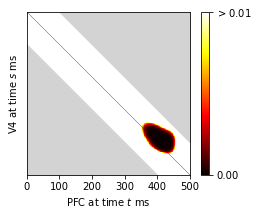

In [243]:
plt.figure(figsize=(4,3))
ldn.imshow(pval_est, cmap='hot', vmin=0, vmax=0.01, time=rec_time, identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')

cbar = plt.colorbar(ticks=[0, 0.01])
cbar.ax.set_yticklabels(['0.00','$>$0.01'])
plt.xlabel(r"PFC at time $t$ ms"); plt.ylabel(r"V4 at time $s$ ms")
plt.yticks([],[])

Text(0, 0.5, 'V4 at time $s$ ms')

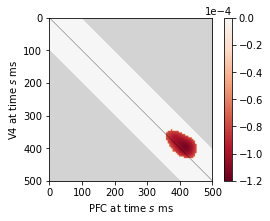

In [175]:
fig, ax = plt.subplots(figsize=(4,3))
ldn.imshow(rej_BH * dspr_est[:num_time,num_time:], time=rec_time, identity=True)

ax.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.clim(-0.00012,0.00012); cbar = plt.colorbar()
cbar.ax.set_ylim(-0.00012,0); cbar.formatter.set_powerlimits((0, 0))
# cbar.ax.set_yticklabels(['-2e-3','-1e-3','0','1e-3','2e-3'])
ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
ax.set_xlabel(r"PFC at time $s$ ms"); ax.set_ylabel(r"V4 at time $s$ ms")

## excursion test

In [82]:
ths_nv = k_hat * alpha / np.sum(roi)

In [83]:
rej_nv = pval_est <= ths_nv
rejs_nv_perm = pvals_perm < ths_nv

In [84]:
rejs_blobs_perm = np.zeros((num_perm, num_time, num_time))
nums_blobs_perm = np.zeros((num_perm,))

for iter_perm in range(num_perm):
    mask_cp = rejs_nv_perm[iter_perm]; iter_blob = 0
    while np.any(mask_cp):
        iter_blob += 1
        queue = [tuple(np.transpose(np.where(mask_cp))[0])]
        mask_cp[queue[0]] = False
        while len(queue) > 0:
            cur = queue.pop(0)
            rejs_blobs_perm[iter_perm, cur[0], cur[1]] = iter_blob
            if cur[0] > 0:
                if mask_cp[cur[0]-1, cur[1]]:
                    queue.append((cur[0]-1, cur[1]))
                    mask_cp[cur[0]-1, cur[1]] = False
            if cur[0] < num_time-1:
                if mask_cp[cur[0]+1, cur[1]]:
                    queue.append((cur[0]+1, cur[1]))
                    mask_cp[cur[0]+1, cur[1]] = False
            if cur[1] > 0:
                if mask_cp[cur[0], cur[1]-1]:
                    queue.append((cur[0], cur[1]-1))
                    mask_cp[cur[0], cur[1]-1] = False
            if cur[1] < num_time-1:
                if mask_cp[cur[0], cur[1]+1]:
                    queue.append((cur[0], cur[1]+1))
                    mask_cp[cur[0], cur[1]+1] = False
    nums_blobs_perm[iter_perm] = iter_blob

In [85]:
mrois_nv_perm = np.zeros(num_perm)
for iter_perm, (pval, rej_b, num_b) \
in enumerate(zip(pvals_perm, rejs_blobs_perm, nums_blobs_perm)):
    rois = np.zeros(int(num_b+1))
    for iter_blob in range(1, int(num_b+1)):
        rois[iter_blob] = np.sum(-np.log(
            pvals_perm[iter_perm][rej_b == iter_blob]))
    mrois_nv_perm[iter_perm] = np.max(rois)

In [86]:
ths_roi = np.quantile(mrois_nv_perm, 0.95)

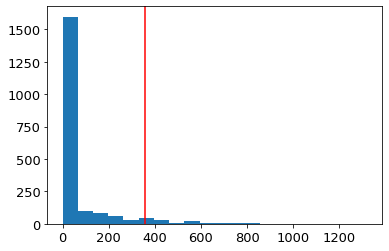

In [87]:
plt.hist(mrois_nv_perm, bins=20)
plt.axvline(x=ths_roi, color='red')

In [88]:
rej_blobs = np.zeros((num_time, num_time))

mask_cp = rej_nv; iter_blob = 0
while np.any(mask_cp):
    iter_blob += 1
    queue = [tuple(np.transpose(np.where(mask_cp))[0])]
    mask_cp[queue[0]] = False
    while len(queue) > 0:
        cur = queue.pop(0)
        rej_blobs[cur[0], cur[1]] = iter_blob
        if cur[0] > 0:
            if mask_cp[cur[0]-1, cur[1]]:
                queue.append((cur[0]-1, cur[1]))
                mask_cp[cur[0]-1, cur[1]] = False
        if cur[0] < num_time-1:
            if mask_cp[cur[0]+1, cur[1]]:
                queue.append((cur[0]+1, cur[1]))
                mask_cp[cur[0]+1, cur[1]] = False
        if cur[1] > 0:
            if mask_cp[cur[0], cur[1]-1]:
                queue.append((cur[0], cur[1]-1))
                mask_cp[cur[0], cur[1]-1] = False
        if cur[1] < num_time-1:
            if mask_cp[cur[0], cur[1]+1]:
                queue.append((cur[0], cur[1]+1))
                mask_cp[cur[0], cur[1]+1] = False
num_blobs = iter_blob

In [89]:
rois_nv = np.zeros(num_blobs+1)
for iter_blob in range(1, num_blobs+1):
    rois_nv[iter_blob] = np.sum(-np.log(pval_est[rej_blobs == iter_blob]))

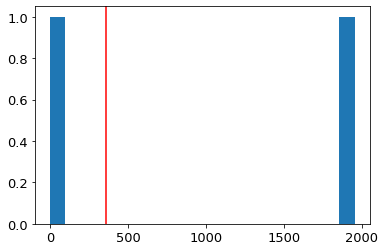

In [90]:
plt.hist(rois_nv, bins=20)
plt.axvline(x=ths_roi, color='red')

In [93]:
np.mean(rois_nv <= mrois_nv_perm[:,None], 0)

array([1., 0.])

## plot

Text(0.5, 0, 'series 2 at time $s$')

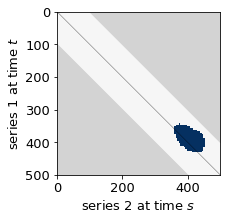

In [91]:
plt.figure(figsize=(3,3))
ldn.imshow(np.isin(rej_blobs, np.where(rois_nv > ths_roi)[0]), time=[rec_time[0], rec_time[1]], identity=True)
plt.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
plt.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.xlim(rec_time[0], rec_time[1]), plt.ylim(rec_time[1], rec_time[0])
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')


# 4. Granger Causality by $\bar{\Sigma}$

In [24]:
bw = 20
order = 10
lambda_reg = lambda_diag
lags_cond = np.array([1,2,7,8,9])

In [25]:
GC_ar = np.zeros([num_time, 2])

In [26]:
for end_time in np.arange(bw, num_time):
    Sigma_tw = (Sigma_est.reshape([2,num_time,2,num_time])
        [:,end_time-bw:end_time,:,end_time-bw:end_time])

    Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
        for i in np.arange(bw-order)], 0).reshape((2*order,2*order))
    
    id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
    id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
    id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
    id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])
    
    lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
    lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
    lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
    lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]
    
    lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
    lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
    lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
    lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

    mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
    mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

    mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
    mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]
    
    GC_ar[end_time] = (np.log(mse_ar1) - np.log(mse_ar12), 
                       np.log(mse_ar2) - np.log(mse_ar21))

## permutation bootstrap

In [27]:
num_perm = Sigmas_perm.shape[0]
GCs_perm = np.zeros([num_perm, num_time, 2])

In [28]:
for iter_perm in np.arange(num_perm):
    for end_time in np.arange(bw, num_time):
        Sigma_tw = (Sigmas_perm[iter_perm].reshape([2,num_time,2,num_time])
            [:,end_time-bw:end_time,:,end_time-bw:end_time])

        Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
            for i in np.arange(bw-order)], 0).reshape((2*order,2*order))

        id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
        id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
        id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
        id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])

        lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
        lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
        lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
        lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]

        lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
        lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
        lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
        lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

        mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
        mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

        mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
        mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]

        GCs_perm[iter_perm,end_time] = \
            (np.log(mse_ar1) - np.log(mse_ar12), 
             np.log(mse_ar2) - np.log(mse_ar21))

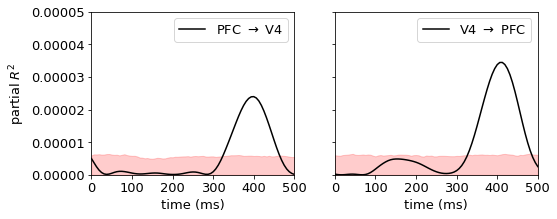

In [58]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,0], label=r'PFC $\rightarrow$ V4', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(GCs_perm[:,bw:,0],0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.00005); plt.xlim(0, 500)
plt.ylabel(r"partial $R^2$"); plt.xlabel("time (ms)"); plt.legend()
# plt.title(r"Granger Causality from PFC to V4")

plt.subplot(1,2,2)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,1], label=r'V4 $\rightarrow$ PFC', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw),
    # np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(GCs_perm[:,bw:,1],0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.00005); plt.xlim(0, 500)
plt.ylabel(r""); plt.xlabel("time (ms)"); plt.legend()
plt.tick_params('y', labelleft=False)

# 5. Granger Causality by $\hat{\Sigma}$

In [60]:
bw = 20
order = 10
lambda_reg = 0
lags_cond = np.array([1,2,7,8,9])

In [61]:
GC_ar = np.zeros([num_time, 2])

In [62]:
for end_time in np.arange(bw, num_time):
    Sigma_tw = (np.linalg.inv(Omega_est).reshape([2,num_time,2,num_time])
        [:,end_time-bw:end_time,:,end_time-bw:end_time])

    Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
        for i in np.arange(bw-order)], 0).reshape((2*order,2*order))
    
    id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
    id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
    id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
    id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])
    
    lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
    lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
    lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
    lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]
    
    lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
    lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
    lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
    lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

    mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
    mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

    mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
    mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]
    
    GC_ar[end_time] = (np.log(mse_ar1) - np.log(mse_ar12), 
                       np.log(mse_ar2) - np.log(mse_ar21))

## permutation bootstrap

In [63]:
num_perm = Sigmas_perm.shape[0]
GCs_perm = np.zeros([num_perm, num_time, 2])

In [64]:
for iter_perm in np.arange(num_perm):
    for end_time in np.arange(bw, num_time):
        Sigma_tw = (np.linalg.inv(Omegas_perm[iter_perm])
                    .reshape([2,num_time,2,num_time])
            [:,end_time-bw:end_time,:,end_time-bw:end_time])

        Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
            for i in np.arange(bw-order)], 0).reshape((2*order,2*order))

        id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
        id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
        id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
        id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])

        lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
        lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
        lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
        lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]

        lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
        lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
        lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
        lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

        mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
        mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

        mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
        mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]

        GCs_perm[iter_perm,end_time] = \
            (np.log(mse_ar1) - np.log(mse_ar12), 
             np.log(mse_ar2) - np.log(mse_ar21))

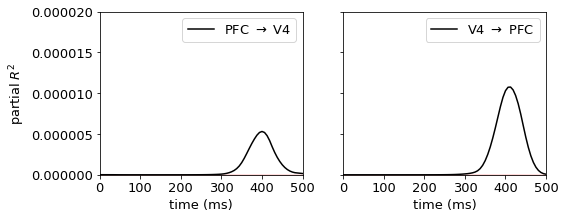

In [66]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,0], label=r'PFC $\rightarrow$ V4', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(GCs_perm[:,bw:,0],0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.00002); plt.xlim(0, 500)
plt.ylabel(r"partial $R^2$"); plt.xlabel("time (ms)"); plt.legend()
# plt.title(r"Granger Causality from PFC to V4")

plt.subplot(1,2,2)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,1], label=r'V4 $\rightarrow$ PFC', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw),
    # np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(GCs_perm[:,bw:,1],0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.00002); plt.xlim(0, 500)
plt.ylabel(r""); plt.xlabel("time (ms)"); plt.legend()
plt.tick_params('y', labelleft=False)

# 6. Granger Causality by $\tilde{\Sigma}$

In [67]:
bw = 20
order = 10
lambda_reg = 0
lags_cond = np.array([1,2,7,8,9])

In [68]:
GC_ar = np.zeros([num_time, 2])

In [70]:
for end_time in np.arange(bw, num_time):
    Sigma_tw = (np.linalg.inv(dspr_est).reshape([2,num_time,2,num_time])
        [:,end_time-bw:end_time,:,end_time-bw:end_time])

    Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
        for i in np.arange(bw-order)], 0).reshape((2*order,2*order))
    
    id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
    id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
    id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
    id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])
    
    lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
    lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
    lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
    lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]
    
    lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
    lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
    lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
    lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

    mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
    mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

    mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
    mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]
    
    GC_ar[end_time] = (np.log(mse_ar1) - np.log(mse_ar12), 
                       np.log(mse_ar2) - np.log(mse_ar21))

## permutation bootstrap

In [71]:
num_perm = Sigmas_perm.shape[0]
GCs_perm = np.zeros([num_perm, num_time, 2])

In [72]:
for iter_perm in np.arange(num_perm):
    for end_time in np.arange(bw, num_time):
        Sigma_tw = (np.linalg.inv(dsprs_perm[iter_perm])
                    .reshape([2,num_time,2,num_time])
            [:,end_time-bw:end_time,:,end_time-bw:end_time])

        Sigma_ar = np.mean([Sigma_tw[:,i+order:i:-1,:,i+order:i:-1] 
            for i in np.arange(bw-order)], 0).reshape((2*order,2*order))

        id_ar1 = np.concatenate([np.arange(order),lags_cond+order])
        id_ar2 = np.concatenate([np.arange(order)+order,lags_cond])
        id_ar12 = np.concatenate([np.arange(order),np.arange(1,order)+order])
        id_ar21 = np.concatenate([np.arange(order)+order,np.arange(1,order)])

        lcov_ar1 = Sigma_ar[np.ix_(id_ar1,id_ar1)]
        lcov_ar2 = Sigma_ar[np.ix_(id_ar2,id_ar2)]
        lcov_ar12 = Sigma_ar[np.ix_(id_ar12,id_ar12)]
        lcov_ar21 = Sigma_ar[np.ix_(id_ar21,id_ar21)]

        lcov_ar1 = lcov_ar1 + lambda_reg * np.eye(lcov_ar1.shape[0])
        lcov_ar2 = lcov_ar2 + lambda_reg * np.eye(lcov_ar2.shape[0])
        lcov_ar12 = lcov_ar12 + lambda_reg * np.eye(lcov_ar12.shape[0])
        lcov_ar21 = lcov_ar21 + lambda_reg * np.eye(lcov_ar21.shape[0])

        mse_ar1 = lcov_ar1[0,0] - lcov_ar1[0,1:]@np.linalg.inv(lcov_ar1[1:,1:])@lcov_ar1[0,1:]
        mse_ar2 = lcov_ar2[0,0] - lcov_ar2[0,1:]@np.linalg.inv(lcov_ar2[1:,1:])@lcov_ar2[0,1:]

        mse_ar12 = lcov_ar12[0,0] - lcov_ar12[0,1:]@np.linalg.inv(lcov_ar12[1:,1:])@lcov_ar12[0,1:]
        mse_ar21 = lcov_ar21[0,0] - lcov_ar21[0,1:]@np.linalg.inv(lcov_ar21[1:,1:])@lcov_ar21[0,1:]

        GCs_perm[iter_perm,end_time] = \
            (np.log(mse_ar1) - np.log(mse_ar12), 
             np.log(mse_ar2) - np.log(mse_ar21))

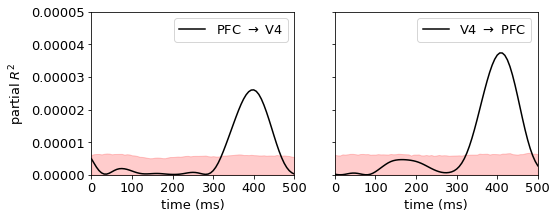

In [74]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,0], label=r'PFC $\rightarrow$ V4', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(GCs_perm[:,bw:,0],0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.00005); plt.xlim(0, 500)
plt.ylabel(r"partial $R^2$"); plt.xlabel("time (ms)"); plt.legend()
# plt.title(r"Granger Causality from PFC to V4")

plt.subplot(1,2,2)
plt.plot(np.linspace(0,500,num_time-bw), #np.arange(num_time-bw)*5+bw*2.5,
         GC_ar[bw:,1], label=r'V4 $\rightarrow$ PFC', color='black')
plt.fill_between(
    np.linspace(0,500,num_time-bw),
    # np.arange(num_time-bw)*5+bw*2.5,
    np.quantile(GCs_perm[:,bw:,1],0.95,0),
    color='red', alpha=0.2)
# plt.fill_between([0,50],[0.001,0.001],color='grey',alpha=1)
# plt.fill_between([450,500],[0.001,0.001],color='grey',alpha=1)
plt.ylim(0, 0.00005); plt.xlim(0, 500)
plt.ylabel(r""); plt.xlabel("time (ms)"); plt.legend()
plt.tick_params('y', labelleft=False)

# 7. Factor Loading Analysis

In [131]:
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML

In [132]:
maps = io.loadmat('/home/hbong/_datasets/Pe160507/maps.mat')
maps = [maps['maps'][0][0][1], maps['maps'][0][0][0]]

coordinates = np.array(np.divmod(np.argsort(np.reshape(maps,(2,-1)), axis=1)[:,:-4], 10)).transpose(1,0,2)

In [133]:
covs = [[np.cov(da) for da in dat] for dat in data]

In [134]:
loadings = [
    np.matmul(covs[0],np.reshape(weight_est[:num_time], (num_time,-1,1)))[...,0],
    np.matmul(covs[1],np.reshape(weight_est[num_time:], (num_time,-1,1)))[...,0]
]

In [135]:
sigma = 1
weights = [np.exp(-np.sum(np.square(
    np.mgrid[0:10:100j,0:10:100j][...,None]
    - (coord+[[0.5],[0.5]])[:,None,None,:]),
    0) / (2*sigma**2))
    for coord in coordinates]

Text(0.5, 0, 't = 0.000sec.')

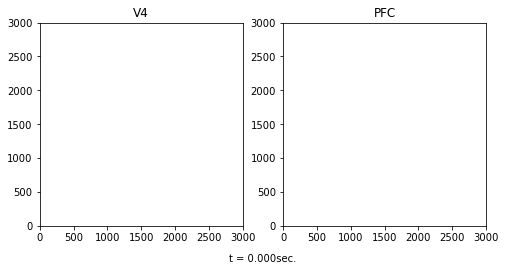

In [170]:
# First set up the figure, the axis, and the plot element we want to animate
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

ax1.set_title("V4"); ax2.set_title("PFC")
img1 = ax1.imshow([[]], cmap='RdBu', origin='lower', extent=((0,3000,0,3000)))
img2 = ax2.imshow([[]], cmap='RdBu', origin='lower', extent=((0,3000,0,3000)))

ax3 = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("t = %.3fsec."%0)

In [171]:
# initialization function: plot the background of each frame
def init():
    img1.set_data([[]]); img1.set_clim(-10,10)
    img2.set_data([[]]); img2.set_clim(-10,10)
    return (img1,img2)

In [172]:
# animation function. This is called sequentially
def animate(i):
    n = 0
    img1.set_data((np.sum(weights[0]*loadings[0][i],-1)/np.sum(weights[0],-1)))
    img2.set_data((np.sum(weights[1]*loadings[1][i],-1)/np.sum(weights[1],-1)))
    ax3.set_xlabel(r't=%fms'%((i-1)*10))
    return (img1,img2)

In [174]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=101, interval=100, blit=True)

In [175]:
HTML(anim.to_html5_video())

In [158]:
fmt = {0.25: '.25', 0.5: '.50', 0.75: '.75'}

/home/hbong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/hbong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


[Text(1, 0.0, '0'),
 Text(1, 0.25, '.25'),
 Text(1, 0.5, '.50'),
 Text(1, 0.75, '.75'),
 Text(1, 1.0, '1')]

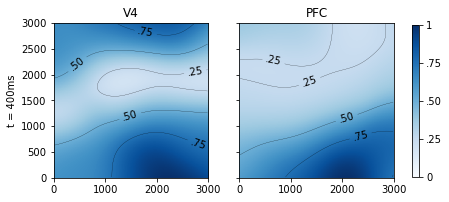

In [159]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,3))
t = 81

load_norm = [np.sum(weight*loading[t],-1)/np.sum(weight,-1)
             for weight, loading in zip(weights, loadings)]
zl = [(load/np.max(load)) for load in load_norm]
img1 = ax1.imshow(zl[0],
                  cmap='Blues', origin='lower', extent=((0,3000,0,3000)))
img2 = ax2.imshow(zl[1],
                  cmap='Blues', origin='lower', extent=((0,3000,0,3000)))
img1.set_clim(0,1)
img2.set_clim(0,1)

ct1 = ax1.contour((np.arange(100)+0.5)*30, (np.arange(100)+0.5)*30,
        zl[0], levels=[0.25, 0.5, 0.75], linewidths=0.2, colors=['black'])
ax1.clabel(ct1, ct1.levels, fmt=fmt, inline=True, fontsize=10)
ct2 = ax2.contour((np.arange(100)+0.5)*30, (np.arange(100)+0.5)*30,
        zl[1],  levels=[0.25, 0.5, 0.75], linewidths=0.2, colors=['black'])
ax2.clabel(ct2, ct2.levels, fmt=fmt, inline=True, fontsize=10)

ax1.set_ylabel("t = 400ms")
ax1.set_title("V4")
ax2.set_title("PFC")
ax2.set_yticklabels([''])
    
fig.subplots_adjust(right=0.8)

ax_cb = fig.add_axes([0.75, 0.15, 0.1, 0.7])
ax_cb.axis('off')
cb = plt.colorbar(ax2.get_images()[0], ticks=[0, 0.25, 0.5, 0.75, 1])
cb.ax.set_yticklabels(['0','.25','.50','.75','1'])

# 8. Power analysis

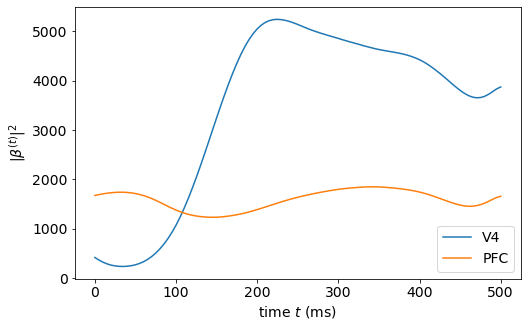

In [230]:
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'], 'size':14})

plt.figure(figsize=(8,5))
plt.plot(np.linspace(*rec_time,num_time,True),
         np.sum(np.square(loadings[0]),1), label='V4')
plt.plot(np.linspace(*rec_time,num_time,True),
         np.sum(np.square(loadings[1]),1), label='PFC')
# plt.axhline(y=0, color='black', lw=1)
plt.xlabel('time $t$ (ms)'); plt.ylabel(r'$\|\beta^{(t)}\|^2$'); plt.legend(loc='lower right')
# plt.title('$\hat{\Sigma}_{12}$ between V4 leading by 40ms and PFC')

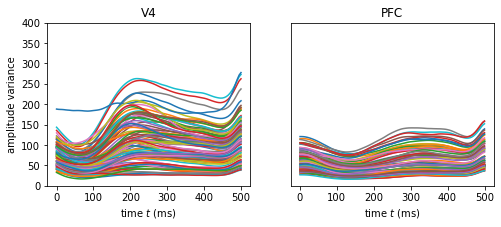

In [164]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.linspace(*rec_time,num_time,True),
         np.var(data[0][:,:,:],2))
plt.ylim(0,400)
plt.title('V4'); plt.xlabel('time $t$ (ms)'); plt.ylabel(r'amplitude variance')

plt.subplot(1,2,2)
plt.plot(np.linspace(*rec_time,num_time,True),
         np.var(data[1][:,:,:],2))
plt.ylim(0,400); plt.yticks([],[])
plt.title('PFC'); plt.xlabel('time $t$ (ms)'); # plt.ylabel(r'$\|\beta^{(t)}\|^2$')

plt.show()

In [166]:
active_electrodes = [
    np.where(L[81] > 0.75 * np.max(L[81]))[0]
    for L in loadings]

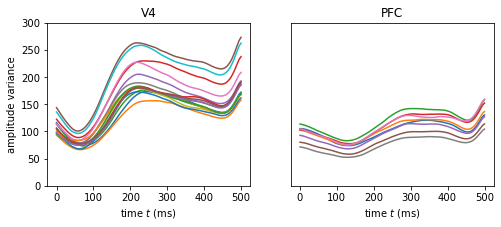

In [167]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.linspace(*rec_time,num_time,True),
         np.var(data[0][:,active_electrodes[0].astype(int),:],2))
plt.ylim(0,300)
plt.title('V4'); plt.xlabel('time $t$ (ms)'); plt.ylabel(r'amplitude variance')

plt.subplot(1,2,2)
plt.plot(np.linspace(*rec_time,num_time,True),
         np.var(data[1][:,active_electrodes[1].astype(int),:],2))
plt.ylim(0,300); plt.yticks([],[])
plt.title('PFC'); plt.xlabel('time $t$ (ms)'); # plt.ylabel(r'$\|\beta^{(t)}\|^2$')

plt.show()

In [168]:
inactive_electrodes = [
    np.where(L[81] < 0.25 * np.max(L[81]))[0]
    for L in loadings]

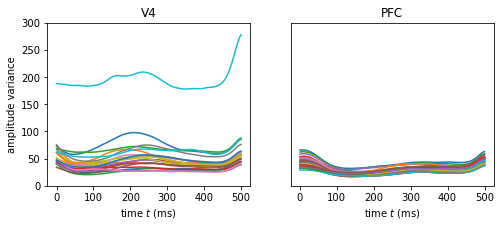

In [169]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.linspace(*rec_time,num_time,True),
         np.var(data[0][:,inactive_electrodes[0].astype(int),:],2))
plt.ylim(0,300)
plt.title('V4'); plt.xlabel('time $t$ (ms)'); plt.ylabel(r'amplitude variance')

plt.subplot(1,2,2)
plt.plot(np.linspace(*rec_time,num_time,True),
         np.var(data[1][:,inactive_electrodes[1].astype(int),:],2))
plt.ylim(0,300); plt.yticks([],[])
plt.title('PFC'); plt.xlabel('time $t$ (ms)'); # plt.ylabel(r'$\|\beta^{(t)}\|^2$')

plt.show()

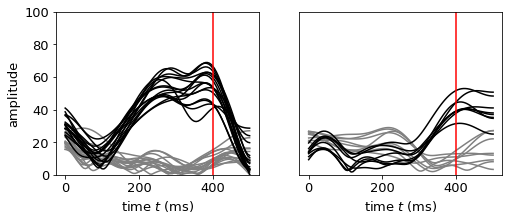

In [61]:
plt.figure(figsize=(8,3))

plt.subplot(1,2,1)
plt.plot(np.linspace(0,500,num_time,True),
         data[0][:,active_electrodes[0].astype(int),1824], color='grey')
plt.plot(np.linspace(0,500,num_time,True),
         data[0][:,active_electrodes[0].astype(int),86], color='black')
plt.axvline(x = 400, color='red')
plt.ylim(0,100)
plt.xlabel('time $t$ (ms)'); plt.ylabel(r'amplitude')

plt.subplot(1,2,2)
plt.plot(np.linspace(0,500,num_time,True),
         data[1][:,active_electrodes[1].astype(int),1824], color='grey')
plt.plot(np.linspace(0,500,num_time,True),
         data[1][:,active_electrodes[1].astype(int),86], color='black')
plt.axvline(x = 400, color='red')
plt.ylim(0,100); plt.yticks([],[])
plt.xlabel('time $t$ (ms)'); # plt.ylabel(r'$\|\beta^{(t)}\|^2$')

plt.show()

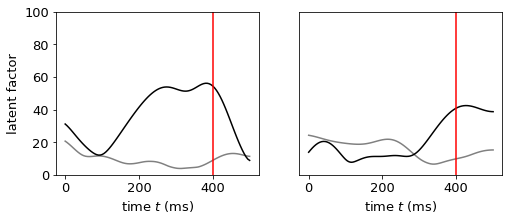

In [62]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,500,num_time,True),
         np.mean(data[0][:,active_electrodes[0].astype(int),1824],1), color='grey')
plt.plot(np.linspace(0,500,num_time,True),
         np.mean(data[0][:,active_electrodes[0].astype(int),86],1), color='black')
plt.axvline(x = 400, color='red')
plt.ylim(0,100)
plt.xlabel('time $t$ (ms)'); plt.ylabel(r'latent factor')

plt.subplot(1,2,2)
plt.plot(np.linspace(0,500,num_time,True),
         np.mean(data[1][:,active_electrodes[1].astype(int),1824],1), color='grey')
plt.plot(np.linspace(0,500,num_time,True),
         np.mean(data[1][:,active_electrodes[1].astype(int),86],1), color='black')
plt.axvline(x = 400, color='red')
plt.ylim(0,100); plt.yticks([],[])
plt.xlabel('time $t$ (ms)'); # plt.ylabel(r'$\|\beta^{(t)}\|^2$')

plt.show()

# 9. Animations

In [101]:
%matplotlib inline

In [102]:
from matplotlib import animation, rc
from IPython.display import HTML

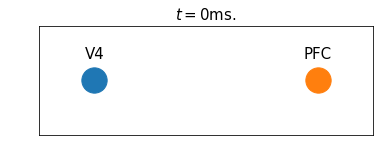

In [166]:
fig, ax = plt.subplots(1,1, figsize=(6,2))

# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.xlabel("t = %.3fsec."%0)

ax.scatter(-1,0,s=20*2**5); ax.text(-1,0.2,'V4',fontsize=15, horizontalalignment='center')
ax.scatter(1,0,s=20*2**5); ax.text(1,0.2,'PFC',fontsize=15, horizontalalignment='center')
ax.set_xlim(-1.5,1.5); ax.set_ylim(-0.5,0.5)

arrow, = ax.plot([],[], lw=5, markersize=15, color='black')
time_text = ax.set_title(r'$t = %d$ms.'%0,fontsize=15)

In [167]:
# initialization function: plot the background of each frame
def init_g():
    arrow.set_data([], [])
    return (arrow, time_text)

In [171]:
def animate_g(i):
    if i >= 70 and i <= 90:
        arrow.set_data([-0.8,0.8],[0,0])
        arrow.set_marker('>')
        arrow.set_markevery([1])
    
#     elif i >= 31 and i <= 35:
#         arrow.set_data([-0.8,0.8],[0,0])
#         arrow.set_marker('<')
#         arrow.set_markevery([0])
        
    else:
        arrow.set_data([],[])
    time_text.set_text(r't = %dms'%((i-1)*5))
    return (arrow, time_text)

In [172]:
anim_g = animation.FuncAnimation(fig, animate_g, init_func=init_g,
                                 frames=101, interval=25, blit=True)

In [173]:
HTML(anim_g.to_html5_video())

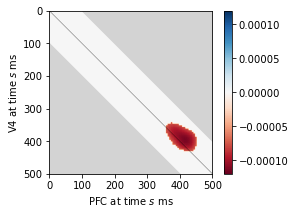

In [161]:
fig, ax = plt.subplots(figsize=(4,3))
ldn.imshow(rej_BH * dspr_est[:num_time,num_time:], time=rec_time, identity=True)

ax.fill_between((b_time[offset_cross], rec_time[1]), 
                (rec_time[0], rec_time[0]), 
                (rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), color='lightgray')
ax.fill_between((rec_time[0], rec_time[1]-b_time[offset_cross]+rec_time[0]), 
                (b_time[offset_cross], rec_time[1]), 
                (rec_time[1], rec_time[1]), color='lightgray')
plt.clim(-0.00012,0.00012); cbar = plt.colorbar(ticks=[-0.0001, -0.00005, 0.0, 0.00005, 0.0001])
# cbar.ax.set_yticklabels(['-2e-3','-1e-3','0','1e-3','2e-3'])
ax.set_xlim(rec_time[0], rec_time[1]); ax.set_ylim(rec_time[1], rec_time[0])
ax.set_xlabel(r"PFC at time $s$ ms"); ax.set_ylabel(r"V4 at time $s$ ms")

line, = plt.plot([-500, 0], [500, 0], color='red')

In [162]:
# initialization function: plot the background of each frame
def init_p():
    return (line,)

In [163]:
def animate_p(i):
    line.set_data([-500+i*10, i*10], [500, 0])
    return (line,)

In [164]:
anim_p = animation.FuncAnimation(fig, animate_p, init_func=init_p,
                                 frames=101, interval=25, blit=True)

In [165]:
HTML(anim_p.to_html5_video())